In [2]:
import pickle

with open('base_dataset_numerical_minmax.pkl','rb') as file:
  data=pickle.load(file)

data.shape

(10127, 21)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
##데이터셋 분리

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

y=data["Attrition_Flag"]
x=data.drop(["Attrition_Flag"],axis=1)

X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)

(7088, 20) (3039, 20)


In [8]:
##lightgbm 모델 적용(하이퍼 파라미터 최적화 이전)

import lightgbm as lgb

model=lgb.LGBMClassifier(random_state=0)
model.fit(X_train, y_train)

y_predict=model.predict(X_test)


[LightGBM] [Info] Number of positive: 1139, number of negative: 5949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1788
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160694 -> initscore=-1.653072
[LightGBM] [Info] Start training from score -1.653072


confusion matrix value:
 [[2526   25]
 [  66  422]] 

Accuracy:0.9701
Precision:0.9441
Recall:0.8648
F1:0.9027


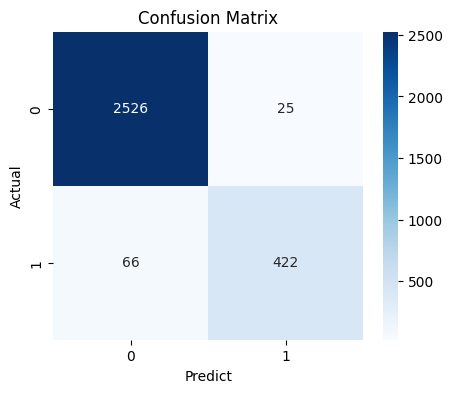

In [7]:
## 모델 성능 점검

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm=confusion_matrix(y_test, y_predict)

print("confusion matrix value:\n",cm,"\n")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

Accuracy = accuracy_score(y_test, y_predict)
Precision = precision_score(y_test, y_predict)
Recall = recall_score(y_test, y_predict)
F1 = f1_score(y_test, y_predict)

print("Accuracy:%.4f"%Accuracy)
print("Precision:%.4f"%Precision)
print("Recall:%.4f"%Recall)
print("F1:%.4f"%F1)

In [10]:
## 그리드서치를 통한 하이퍼파라미터 최적화

from sklearn.model_selection import GridSearchCV

lgbm_model=lgb.LGBMClassifier(random_state=0)

param_grid = {
    'num_leaves': [31, 63,127],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100,1000],
    'min_child_samples': [10,20,30],
}

grid_search = GridSearchCV(lgbm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=0),
             param_grid={'learning_rate': [0.1, 0.01],
                         'min_child_samples': [10, 20, 30],
                         'n_estimators': [50, 100, 1000],
                         'num_leaves': [31, 63, 127]})

accuracy=0.9733
confusion matrix value:
 [[2531   20]
 [  61  427]] 

Accuracy:0.9733
Precision:0.9553
Recall:0.8750
F1:0.9134


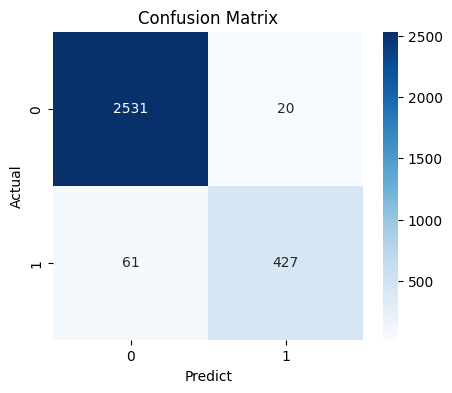

In [11]:
## 하이퍼 파라미터 최적화 후 성능 검

accuracy=grid_search.score(X_test, y_test)
y_predict=grid_search.predict(X_test)

print(f'{accuracy=:.4f}')

cm=confusion_matrix(y_test, y_predict)

print("confusion matrix value:\n",cm,"\n")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

Accuracy = accuracy_score(y_test, y_predict)
Precision = precision_score(y_test, y_predict)
Recall = recall_score(y_test, y_predict)
F1 = f1_score(y_test, y_predict)

print("Accuracy:%.4f"%Accuracy)
print("Precision:%.4f"%Precision)
print("Recall:%.4f"%Recall)
print("F1:%.4f"%F1)

In [12]:
## 이탈고객이 될 확률 (predict_proba)

class_probabilities = grid_search.predict_proba(data.drop(["Attrition_Flag"],axis=1))

df_pro=pd.DataFrame(class_probabilities[:,1], columns=["Attrition_probabilities"])

df_pro

,Attrition_probabilities
0,4.246751e-12
1,1.269807e-11
2,3.926250e-12
3,7.786074e-11
4,6.028423e-06
...,...
10122,7.225061e-09
10123,9.999514e-01
10124,9.999998e-01
10125,9.999999e-01


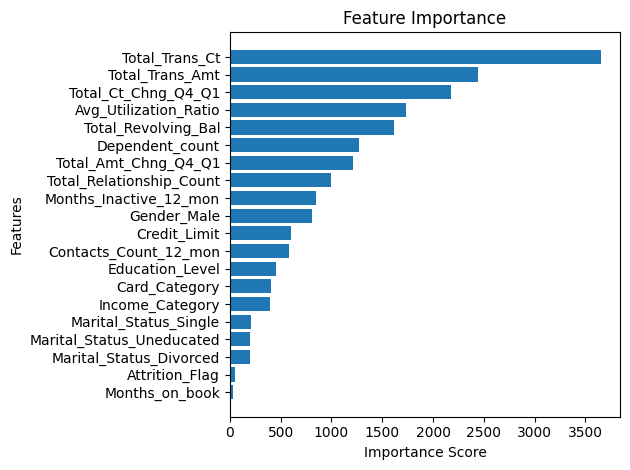

In [13]:
## features importance

importances = grid_search.best_estimator_.feature_importances_
import numpy as np

indices=np.argsort(importances)
sorted_feature_names = [data.columns[1:][i] for i in indices]
# Create plot
plt.figure()
plt.title("Feature Importance")
ticks = range(len(data.columns[1:]))
plt.barh(ticks, importances[indices], align="center")
plt.yticks(ticks, sorted_feature_names)
plt.ylabel("Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()